# Project Title: Analysis of A Gold Mining Operation 

Introduction: The aim of this analysis is to devise a machine learning model that can predict the amount of gold recovered from gold ore for the company Zyfra. The model will be designed to enhance the production process and remove unprofitable parameters for Zyfra. Zyfra is a company that is focused on crafting solutions to improve the process of mining gold. The dataset examined is from their warehouse. The following steps will be taken: 
1. Data will be preprocessed including a verification that the recovery calculation is correct and comparison of the training set and the test set. Any missing values will be examined and targets choosen.  
2. The concentrations for each metal at various stages will be compared and anything that needs to be removed. The feed size distributions between the training and test sets will be examined. 
3. Models will be trained using various models. 
4. The sMAPE scores will be calcualted and the superior scoring model will be choosen as the final mode. 
a. The model will be trained on the full training set and final sMAPE will be determined based on the test set. 
b. It will be compared to a dummy model. 


# Prepare the Dataset 

In [1]:
#Import Libraries 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import os 
import warnings 
from tqdm import tqdm 
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV 
from sklearn.metrics import make_scorer, mean_absolute_error,r2_score,mean_squared_error  
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.dummy import DummyRegressor 
from sklearn.feature_selection import RFE 
from sklearn.impute import SimpleImputer 

In [2]:
#Importing datasets 

df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')


In [3]:
#Examining the datasets 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [4]:
#Explore general stats of dataset
df_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


In [5]:
#Examining the datasets 
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [6]:
#Explore general stats of dataset
df_test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


In [7]:
#Examining the datasets 
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [8]:
#Explore general stats of dataset
df_full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,...,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615.000000,22616.000000,22597.000000,22615.000000
mean,4.781559,9.095308,8.640317,40.001172,67.447488,8.923690,2.488252,9.523632,2.827459,140.277672,...,18.205125,-499.878977,14.356474,-476.532613,14.883276,-503.323288,11.626743,-500.521502,17.976810,-519.361465
std,2.030128,3.230797,3.785035,13.398062,11.616034,3.517917,1.189407,4.079739,1.262834,49.919004,...,6.560700,80.273964,5.655791,93.822791,6.372811,72.925589,5.757449,78.956292,6.636203,75.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.018525,8.750171,7.116799,42.383721,63.282393,7.684016,1.805376,8.143576,2.303108,110.177081,...,14.095940,-500.896232,10.882675,-500.309169,10.941299,-500.628697,8.037533,-500.167897,13.968418,-500.981671
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,141.330501,...,18.007326,-499.917108,14.947646,-499.612292,14.859117,-499.865158,10.989756,-499.951980,18.004215,-500.095463
75%,5.862593,10.929839,10.705824,46.111999,72.950836,11.084557,3.287790,11.860824,3.555077,174.049914,...,22.998194,-498.361545,17.977502,-400.224147,18.014914,-498.489381,14.001193,-499.492354,23.009704,-499.526388
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


Description of Data: 
Rougher feed: raw material 
Rougher additions: Xanthate, Sulphate, Depressant (aka flotation reagents) 
Xanthate:flotation activator (aka promoter) 
Sulphate: sodium sulphide 
Depressants: sodium silicate  
Rougher process: flotation  
Rougher tails: residue of product 
Float banks: flotation unit  
Cleaner process: purification 
Rougher Au: rougher gold concentrate 
Final AU: final concentrate of gold 

# Check Recovery Calculation 

Description: I will devise a function to calculate gold recovery. This function will include the following inputs: 
C= rougher.output.concentrate_au 
F=rougher.input.feed_au 
T= rougher.output.tail_au 

This will return the percentage of gold concentrate after the roughing stage. 

Then to determine final recovery after the final purification stage the function will take the following inputs: 
C= final.output.concentrate_au 
F= final.input.feed_au 
T= final.output.tail_au 

It will be necessary to drop the nans prior to this calculation. 

In [9]:
def calc_recov(C,F,T):
    recovery = (C*(F-T))/(F*(C-T)) * 100 
    
    return recovery 

In [10]:
df_train_cut = df_train.dropna(subset=['rougher.output.recovery', 'rougher.output.concentrate_au','rougher.input.feed_au','rougher.output.tail_au'])

In [11]:
recov = df_train_cut ['rougher.output.recovery']
pred_recov = calc_recov(df_train_cut['rougher.output.concentrate_au'],df_train_cut['rougher.input.feed_au'],df_train_cut['rougher.output.tail_au']) 

mean_absolute_error(recov,pred_recov)

9.303415616264301e-15

Description: The recovery equation matches the recovery measurements. 

# Analyze the features not available in the test set

Description: We will examine if there is a difference between the training set and test set. The training set currently has more columns than the test set. Therefore, we will see what is missing. 

In [12]:
df_test_columns = df_test.columns 

In [13]:
drop_columns = df_train.drop(df_test_columns, axis=1)
drop_columns.info 

<bound method DataFrame.info of        final.output.concentrate_ag  final.output.concentrate_pb  \
0                         6.055403                     9.889648   
1                         6.029369                     9.968944   
2                         6.055926                    10.213995   
3                         6.047977                     9.977019   
4                         6.148599                    10.142511   
...                            ...                          ...   
16855                     3.224920                    11.356233   
16856                     3.195978                    11.349355   
16857                     3.109998                    11.434366   
16858                     3.367241                    11.625587   
16859                     3.598375                    11.737832   

       final.output.concentrate_sol  final.output.concentrate_au  \
0                          5.507324                    42.192020   
1                          

Description: The missing values in the test set are due to data that would not be accessible at the start of the extraction process. The test set therefore, represent data that the company would have during real world predictions. It will be helpful to have this list to figure out which data we need to use for predictions. 

# Perform data preprocessing

It will be important to ensure the training dataset includes only the required features and targets. Then to drop any nan values. The table will be split into training features and training targets. The test set will also need to have nan values dropped as well. It will be vital to create a list of columns that have the concentration data for later use and those columns that will need to be dropped from the training set. 

In the description of the dataset it is described as being in chronological order. Although, cross validation will be used later it will still be helpful for best results to shuffle the data after preprocessing. 

In [14]:
targets= ['rougher.output.recovery','final.output.recovery']

conc = ['final.output.concentrate_au','rougher.output.concentrate_au', 'rougher.input.feed_au', 'final.output.concentrate_ag', 'rougher.output.concentrate_ag', 'rougher.input.feed_ag', 'final.output.concentrate_ag', 'rougher.output.concentrate_ag','rougher.input.feed_ag', 'final.output.concentrate_pb', 'rougher.output.concentrate_pb', 'rougher.input.feed_pb', 'final.output.concentrate_sol', 'rougher.output.concentrate_sol', 'rougher.input.feed_sol']

conc_drop = ['final.output.concentrate_sol', 'rougher.output.concentrate_sol', 'final.output.concentrate_pb', 'rougher.output.concentrate_pb', 'final.output.concentrate_ag','rougher.output.concentrate_ag', 'final.output.concentrate_au', 'rougher.output.concentrate_au']





In [15]:
drop_columns = drop_columns.drop(targets,axis=1)
drop_columns = drop_columns.drop(conc_drop,axis=1)
trim_df_train= df_train.drop(drop_columns.columns,axis=1)

In [16]:
trim_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 63 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        16860 non-null  object 
 1   final.output.concentrate_ag                 16788 non-null  float64
 2   final.output.concentrate_pb                 16788 non-null  float64
 3   final.output.concentrate_sol                16490 non-null  float64
 4   final.output.concentrate_au                 16789 non-null  float64
 5   final.output.recovery                       15339 non-null  float64
 6   primary_cleaner.input.sulfate               15553 non-null  float64
 7   primary_cleaner.input.depressant            15598 non-null  float64
 8   primary_cleaner.input.feed_size             16860 non-null  float64
 9   primary_cleaner.input.xanthate              15875 non-null  float64
 10  primary_cl

Description: 

In [17]:
#Addressing missing values 
trim_df_train = trim_df_train.ffill()

In [18]:
#Check duplicates 
trim_df_train.duplicated().sum()

0

Description: The forward fill mehtod was used to maintain the temporal sequence of observations and to manage missing values. Forward fill will promote non-null values forward eliminating missing values and filling these with the preceding non-null value. This effectively keeps the data's sequential order and addressed missing values. 

# #Splitting sets into features and targets 

In [19]:
# setting features and targets for training set 
target_train = trim_df_train [targets]
features_train = trim_df_train.drop(targets, axis=1).drop('date',axis=1).drop(conc_drop, axis=1)

final_conc = trim_df_train[conc]

In [20]:
#reviewing features 
features_train

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,-500.888152,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,123.381787,8.028927,6.50,1.304232,1648.421193,-400.382169,1648.742005,-400.359661,1648.578230,-399.363624,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
16856,120.878188,7.962636,6.50,1.302419,1649.820162,-399.930973,1649.357538,-399.721222,1648.656192,-401.195834,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
16857,105.666118,7.955111,6.50,1.315926,1649.166761,-399.888631,1649.196904,-399.677571,1647.896999,-399.988275,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
16858,98.880538,7.984164,6.50,1.241969,1646.547763,-398.977083,1648.212240,-400.383265,1648.917387,-399.521344,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


In [21]:
#data shuffling 
target_train = target_train.sample (frac=1, random_state=0)
features_train = features_train.sample(frac=1, random_state=0)

conc_train = final_conc.sample (frac=1, random_state=0)

In [22]:
#reviewing targets for training set 
target_train.head()

,rougher.output.recovery,final.output.recovery
15595,89.846488,75.526628
12938,94.292663,74.362554
13659,93.586974,76.168808
6317,89.483550,71.788920
15636,94.755673,81.608864


In [23]:
#reviewing features for training set 
features_train.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
15595,122.832333,7.579891,6.443333,1.092322,1701.492510,-498.930432,1701.369266,-500.183981,1701.354687,-497.333750,...,30.012261,-499.671008,22.927886,-499.549444,20.000769,-500.205475,15.008221,-499.925765,17.983455,-500.086309
12938,179.731047,15.991746,6.820000,1.335643,1699.905644,-498.572482,1695.083511,-499.922241,1701.312252,-498.877403,...,23.005597,-500.295804,14.897285,-500.119256,17.954706,-499.866248,11.979044,-500.227535,11.973012,-499.382210
13659,144.637289,6.012892,7.290000,0.883207,1789.033468,-500.741082,1800.846438,-499.793491,1800.233232,-500.924347,...,23.061089,-502.015230,16.057388,-501.191962,21.971451,-501.192381,13.989506,-500.075307,13.011942,-500.877996
6317,136.413172,8.013200,7.750000,0.996200,1598.227329,-499.792067,1599.654634,-499.879991,1596.812067,-498.145317,...,24.968479,-499.214668,22.986167,-499.211996,23.004433,-499.567343,20.001232,-500.115807,24.989998,-599.905391
15636,167.977408,6.979651,7.300000,1.017860,1699.791360,-499.900171,1700.945441,-499.930238,1701.414751,-499.434647,...,29.995077,-500.253038,22.980202,-499.475466,19.993750,-500.346499,14.763346,-499.931439,17.964111,-500.651978


In [24]:
#reviewing 
conc_train.head()

,final.output.concentrate_au,rougher.output.concentrate_au,rougher.input.feed_au,final.output.concentrate_ag,rougher.output.concentrate_ag,rougher.input.feed_ag,final.output.concentrate_ag,rougher.output.concentrate_ag,rougher.input.feed_ag,final.output.concentrate_pb,rougher.output.concentrate_pb,rougher.input.feed_pb,final.output.concentrate_sol,rougher.output.concentrate_sol,rougher.input.feed_sol
15595,46.381322,17.407358,6.622279,4.151463,11.869672,6.916367,4.151463,11.869672,6.916367,10.744395,10.094682,3.717486,6.780448,29.064798,40.038658
12938,42.143984,8.025801,11.806550,6.209688,5.479148,12.905219,6.209688,5.479148,12.905219,10.953795,3.734205,6.095087,10.666312,11.960304,37.987529
13659,45.360035,16.954455,6.576319,4.571268,11.265128,7.506788,4.571268,11.265128,7.506788,11.458601,7.832337,3.238918,8.976258,23.311402,39.713116
6317,43.121756,22.841318,9.457796,5.515276,15.091683,9.623453,5.515276,15.091683,9.623453,11.553113,9.549745,4.466811,16.065064,35.810925,33.779020
15636,45.763406,18.048345,8.973826,5.176435,11.869903,7.895337,5.176435,11.869903,7.895337,8.671377,5.909881,2.349874,8.200905,28.627985,41.590576


Description: The indexes now match positions. 

Some of the groups of featuers have similar scales. Although, some standardization may be helpful, it is not necessary at this point to standardize the data. If need be this can be done later. Linear regression may benefit from standardization, however random forest regression will not be impacted. 

The test set can be treated in a similar way to the training set. The test set does not have target values due to it being available prior to the extraction process. It will be helpful to have a target available for comparison. Therefore, an extra dataset will be devised that has the full data for the test observations. Then the target values can be put into a series for later analysis. 

In [25]:
# Examining the test & full set for duplicates 
df_test.date.duplicated().sum()
df_full.date.duplicated().sum()

0

In [26]:
#Addressing missing values 
test_full = df_full[df_full.date.isin(df_test.date)]
test_full_trim = test_full.ffill()

In [27]:
# Splitting test set into features and target 
features_test = test_full_trim.drop('date',axis=1).drop(drop_columns.columns, axis=1).drop(targets,axis=1).drop(conc_drop, axis=1).reset_index(drop=True)
target_test = test_full_trim[targets].reset_index(drop=True)

conc_test = test_full_trim [conc].reset_index(drop=True)

In [28]:
#review features for test set 
features_test 

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5851,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,-499.599127,...,13.995957,-500.157454,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909
5852,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,-503.587739,...,16.749781,-496.031539,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761
5853,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,-520.667442,...,19.994130,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882
5854,179.697158,15.438979,8.070000,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,-487.479567,...,19.958760,-499.958750,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284


In [29]:
#Shuffling 
features_test = features_test.sample(frac=1, random_state=0)
target_test = target_test.sample(frac=1, random_state=0)

conc_test = conc_test.sample(frac=1, random_state=0)

In [30]:
#Checking on features for test set 
features_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
4031,213.043191,6.490066,6.65,2.391526,1.502140e+03,-499.100848,1.502130e+03,-488.368088,1.496555e+03,-506.723378,...,17.994600,-499.358412,16.006259,-399.352233,12.955698,-499.834036,9.945527,-499.959387,13.986509,-499.566150
1790,221.732738,8.684621,7.16,0.945199,1.596040e+03,-500.679427,1.601048e+03,-500.211949,1.598081e+03,-509.774330,...,15.971493,-501.032805,13.984239,-502.369591,14.882311,-501.346112,14.022224,-500.334287,22.003192,-503.541797
608,5.458001,0.066355,7.68,0.000693,2.312186e-20,-797.069337,3.689908e-20,-799.921763,2.068183e-22,-799.926886,...,0.000000,-799.625642,0.000000,-799.815741,-0.166369,-798.021313,0.646338,-800.016229,0.229378,-761.170351
5743,186.466071,15.023432,7.20,1.013730,1.541590e+03,-399.779341,1.541401e+03,-407.188027,1.342887e+03,-387.713862,...,19.984213,-500.861134,15.048666,-499.546234,10.963957,-501.963224,8.956150,-499.836167,11.992167,-500.870145
5744,190.674269,15.018264,7.20,0.997910,1.477806e+03,-399.990357,1.478673e+03,-402.228728,1.342709e+03,-396.890908,...,19.960366,-500.739173,14.929482,-500.007043,10.972177,-500.726236,8.964911,-499.876452,12.005236,-500.726195


In [31]:
#Checking on target for test set 
target_test.head()

,rougher.output.recovery,final.output.recovery
4031,88.072093,64.915883
1790,88.831665,68.178405
608,89.665085,41.146342
5743,83.325755,78.419020
5744,83.325755,75.712979


In [32]:
#Checking 
conc_test.head()

,final.output.concentrate_au,rougher.output.concentrate_au,rougher.input.feed_au,final.output.concentrate_ag,rougher.output.concentrate_ag,rougher.input.feed_ag,final.output.concentrate_ag,rougher.output.concentrate_ag,rougher.input.feed_ag,final.output.concentrate_pb,rougher.output.concentrate_pb,rougher.input.feed_pb,final.output.concentrate_sol,rougher.output.concentrate_sol,rougher.input.feed_sol
4031,45.718941,19.005760,7.504443,4.494467,11.432113,6.753147,4.494467,11.432113,6.753147,10.835033,8.504521,3.435767,8.948104,31.654671,46.005772
1790,48.785532,20.990325,9.548833,3.641227,12.273978,9.285046,3.641227,12.273978,9.285046,8.652598,7.361151,3.752739,10.491327,27.124606,39.443913
608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5743,43.705584,19.184580,11.997088,5.981235,13.240239,11.962715,5.981235,13.240239,11.962715,10.428193,8.306362,5.748571,10.701582,31.074879,38.612183
5744,43.267546,19.975244,11.700229,6.174575,13.279724,11.582244,6.174575,13.279724,11.582244,10.662802,8.292289,5.437818,9.651777,32.359935,39.948652


Description: The features and targets match the necessary indexes.

# Analyze the data


The rougher output concentrate, primary cleaner concentrate and final output concentrate will be analyzed to see the changes in the concentration of metals throughout the purification stages. 

In [33]:
# show ag 
display(df_train['rougher.output.concentrate_ag'].describe()) 
display(df_train['primary_cleaner.output.concentrate_ag'].describe()) 
display(df_train['final.output.concentrate_ag'].describe()) 

count    16778.000000
mean        10.580475
std          4.451490
min          0.000000
25%          9.970467
50%         11.459862
75%         13.280031
max         24.480271
Name: rougher.output.concentrate_ag, dtype: float64

count    16778.000000
mean         7.422640
std          3.105117
min          0.000000
25%          6.612584
50%          7.997143
75%          9.399463
max         16.081632
Name: primary_cleaner.output.concentrate_ag, dtype: float64

count    16788.000000
mean         4.716907
std          2.096718
min          0.000000
25%          3.971262
50%          4.869346
75%          5.821176
max         16.001945
Name: final.output.concentrate_ag, dtype: float64

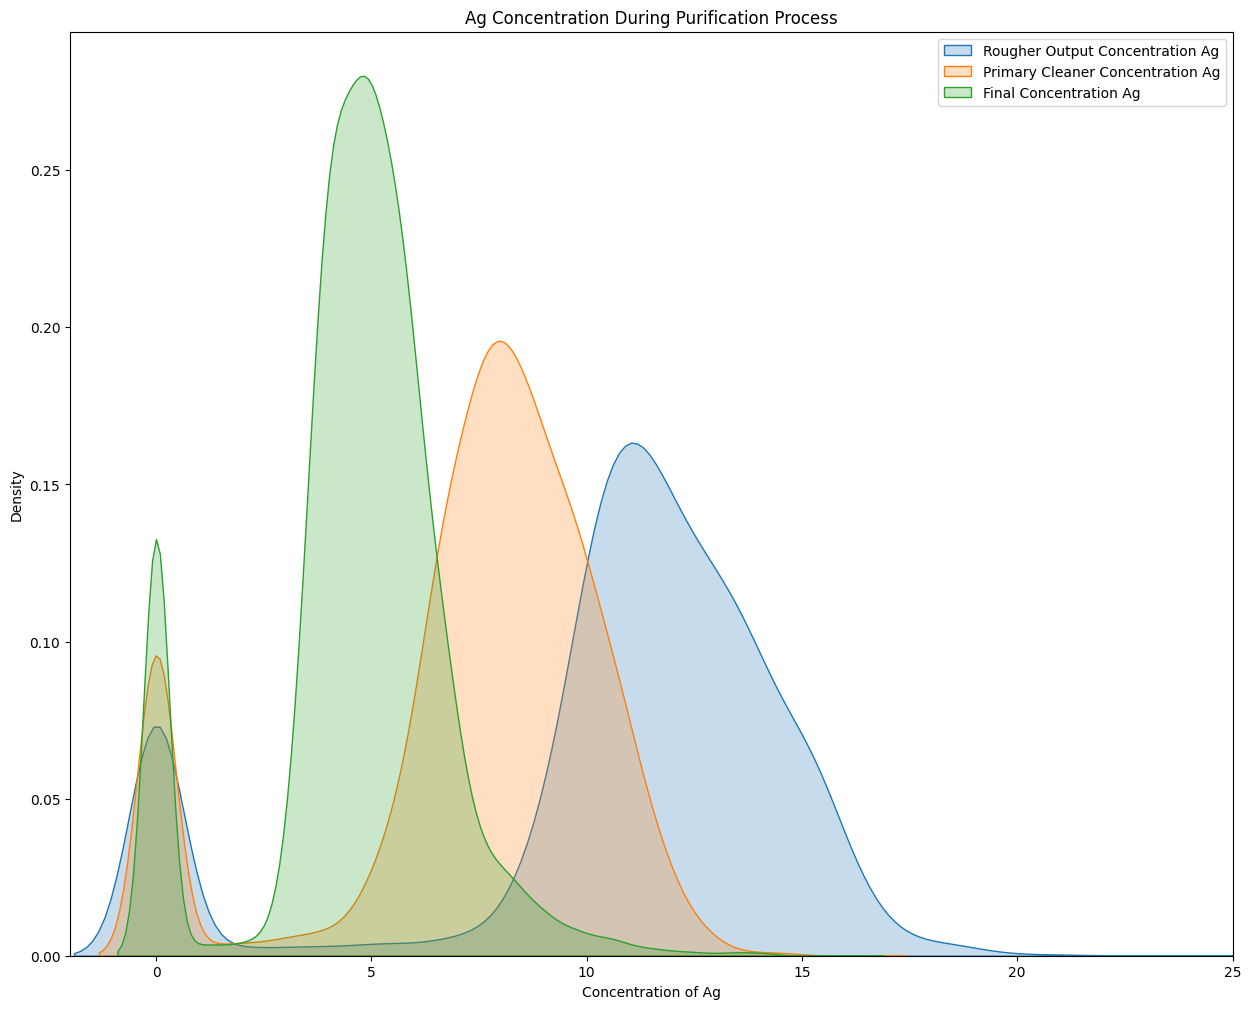

In [34]:
#Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage

#plot the findings 
plt.figure(figsize=[15,12])

sns.kdeplot(df_train['rougher.output.concentrate_ag'],fill=True, label='Rougher Output Concentration Ag')
sns.kdeplot(df_train['primary_cleaner.output.concentrate_ag'],fill=True, label='Primary Cleaner Concentration Ag')
sns.kdeplot(df_train['final.output.concentrate_ag'],fill=True, label='Final Concentration Ag')

plt.legend()
plt.title('Ag Concentration During Purification Process')
plt.xlabel('Concentration of Ag')
plt.xlim(-2,25)

plt.show()

In [35]:
#show pb 
display(df_train['rougher.output.concentrate_pb'].describe()) 
display(df_train['primary_cleaner.output.concentrate_pb'].describe()) 
display(df_train['final.output.concentrate_pb'].describe()) 

count    16778.000000
mean         6.880322
std          2.928757
min          0.000000
25%          6.346373
50%          7.583773
75%          8.503498
max         18.394042
Name: rougher.output.concentrate_pb, dtype: float64

count    16502.000000
mean         8.620294
std          3.815415
min          0.000000
25%          7.146794
50%          9.618910
75%         11.131134
max         17.081278
Name: primary_cleaner.output.concentrate_pb, dtype: float64

count    16788.000000
mean         9.113559
std          3.389495
min          0.000000
25%          8.825748
50%         10.065316
75%         11.054809
max         17.031899
Name: final.output.concentrate_pb, dtype: float64

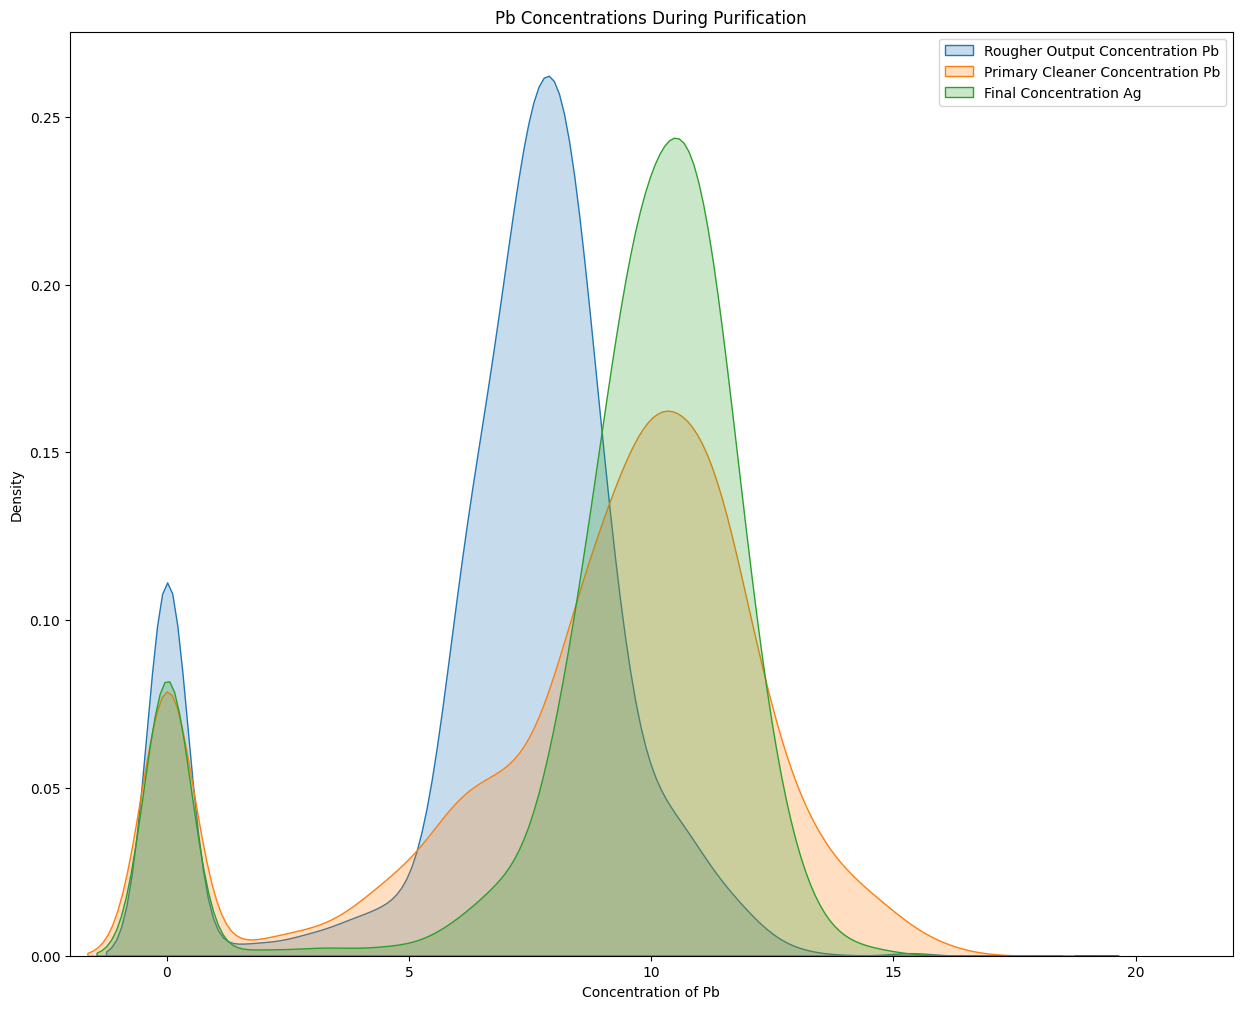

In [36]:
#Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage

#plot the findings 
plt.figure(figsize=[15,12])

sns.kdeplot(df_train['rougher.output.concentrate_pb'],fill=True, label='Rougher Output Concentration Pb')
sns.kdeplot(df_train['primary_cleaner.output.concentrate_pb'],fill=True, label='Primary Cleaner Concentration Pb')
sns.kdeplot(df_train['final.output.concentrate_pb'],fill=True, label='Final Concentration Ag')

plt.legend()
plt.title('Pb Concentrations During Purification')
plt.xlabel('Concentration of Pb')
plt.xlim(-2,22)

plt.show()

In [37]:
#show au

display(df_train['rougher.output.concentrate_au'].describe()) 
display(df_train['primary_cleaner.output.concentrate_au'].describe()) 
display(df_train['final.output.concentrate_au'].describe()) 

count    16778.000000
mean        17.401541
std          6.921875
min          0.000000
25%         17.443663
50%         19.644663
75%         21.224486
max         28.522811
Name: rougher.output.concentrate_au, dtype: float64

count    16778.000000
mean        29.164596
std         10.983718
min          0.000000
25%         29.631129
50%         32.648867
75%         35.011318
max         45.933934
Name: primary_cleaner.output.concentrate_au, dtype: float64

count    16789.000000
mean        39.467217
std         13.917227
min          0.000000
25%         42.055722
50%         44.498874
75%         45.976222
max         53.611374
Name: final.output.concentrate_au, dtype: float64

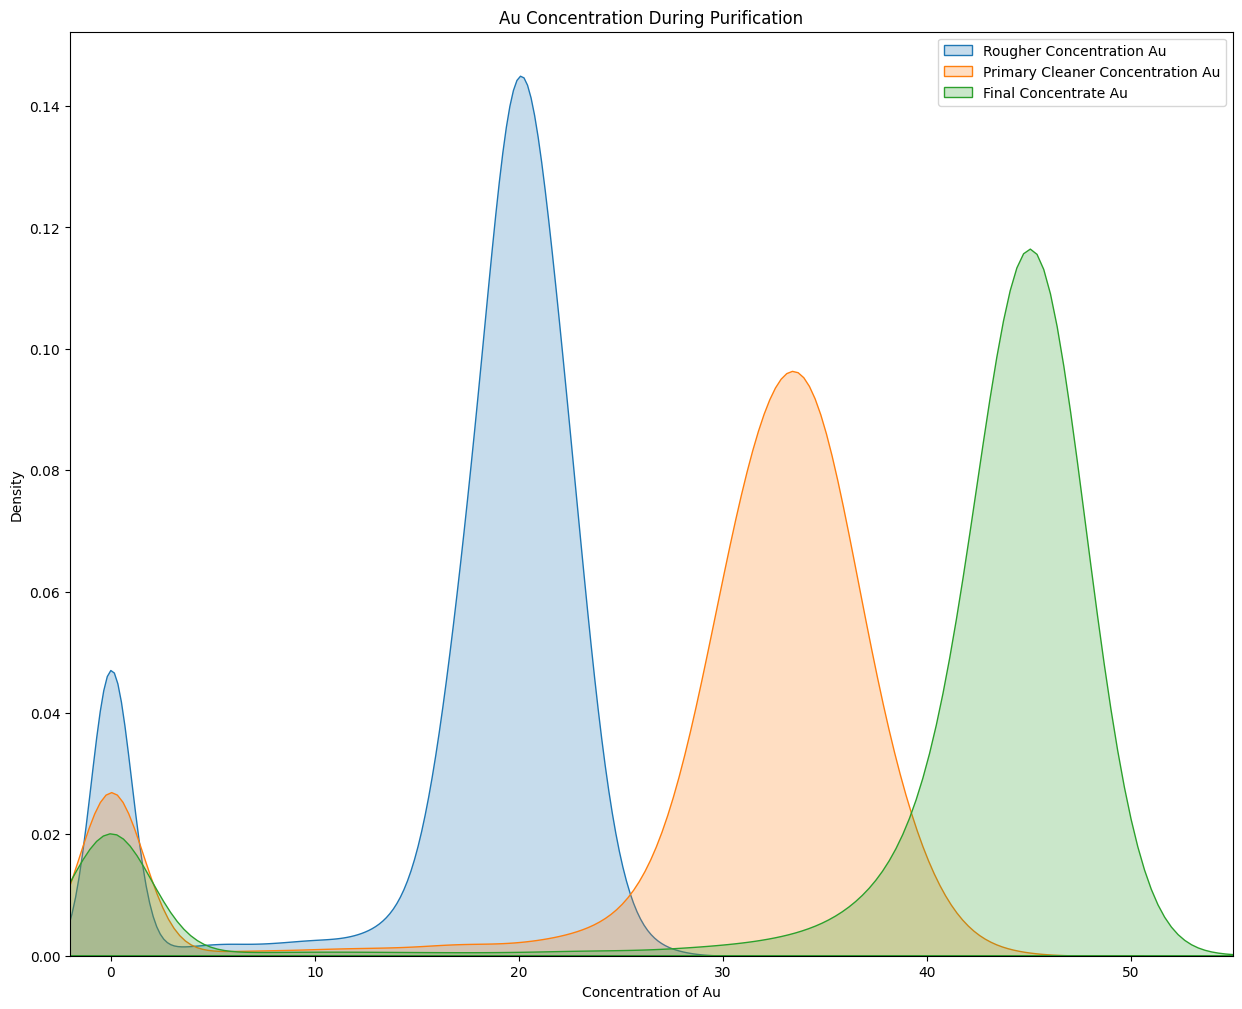

In [38]:
#Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage

#plot the findings 
plt.figure(figsize=[15,12])

sns.kdeplot(df_train['rougher.output.concentrate_au'],fill=True, label='Rougher Concentration Au')
sns.kdeplot(df_train['primary_cleaner.output.concentrate_au'],fill=True, label='Primary Cleaner Concentration Au')
sns.kdeplot(df_train['final.output.concentrate_au'],fill=True, label='Final Concentrate Au')

plt.legend()
plt.title('Au Concentration During Purification')
plt.xlabel('Concentration of Au')
plt.xlim(-2,55)

plt.show()

Description: In observing the graphs several observations can be made:
a. During Ag the concentration becomes greater at each stage. 
b. During Pb's cleaning process the concentration of Pb flucuates then stabilizes. 
c. Au's concentration flucuates than stabilizes. 

There are some outliers that should be removed to clean up the dataset for Au, especially. These outliers can be removed with a custom function. 

In [39]:
# Devising a function to remove abnormalties 

def trim_rows(features_df, target_df, conc_df, features_col=0, target_col=0, condition = 'greater', indexes=0):
    print("Length of original dataframes:", features_df.shape[0])
    
    if condition == 'greater':
        bad_rows=features_df[features_df[features_col]>= conc_df[target_col]].index
    elif condition == 'less':
        bad_rows=features_df[features_df[features_col]>= conc_df[target_col]].index
    else:
        bad_rows = indexes 
        
    features_df = features_df.drop(bad_rows, errors='ignore')
    target_df = target_df.drop(bad_rows, errors='ignore')
    conc_df = conc_df.drop(bad_rows, errors='ignore')
    
    print("Length of trimmed dataframes:", features_df.shape[0])
    
    return features_df, target_df, conc_df
    return features_df, target_df, conc_df


In [40]:
#Trimming down the training set 
features_train, target_train, conc_train = trim_rows(features_train, target_train, conc_train, 'rougher.input.feed_au','rougher.output.concentrate_au')



Length of original dataframes: 16860
Length of trimmed dataframes: 14703


In [41]:
#Trimming down the training set 
features_train, target_train, conc_train = trim_rows(features_train, target_train, conc_train, 'rougher.input.feed_au','final.output.concentrate_au')



Length of original dataframes: 14703
Length of trimmed dataframes: 14494


In [42]:
#Trimming down the training set 
features_test,target_test,conc_test = trim_rows(features_test,target_test,conc_test, 'rougher.input.feed_au','rougher.output.concentrate_au')



Length of original dataframes: 5856
Length of trimmed dataframes: 5366


In [43]:
#Trimming down the training set 
features_test, target_test, conc_test = trim_rows( features_test,target_test, conc_test, 'rougher.input.feed_au', 'final.output.concentrate_au')



Length of original dataframes: 5366
Length of trimmed dataframes: 5270


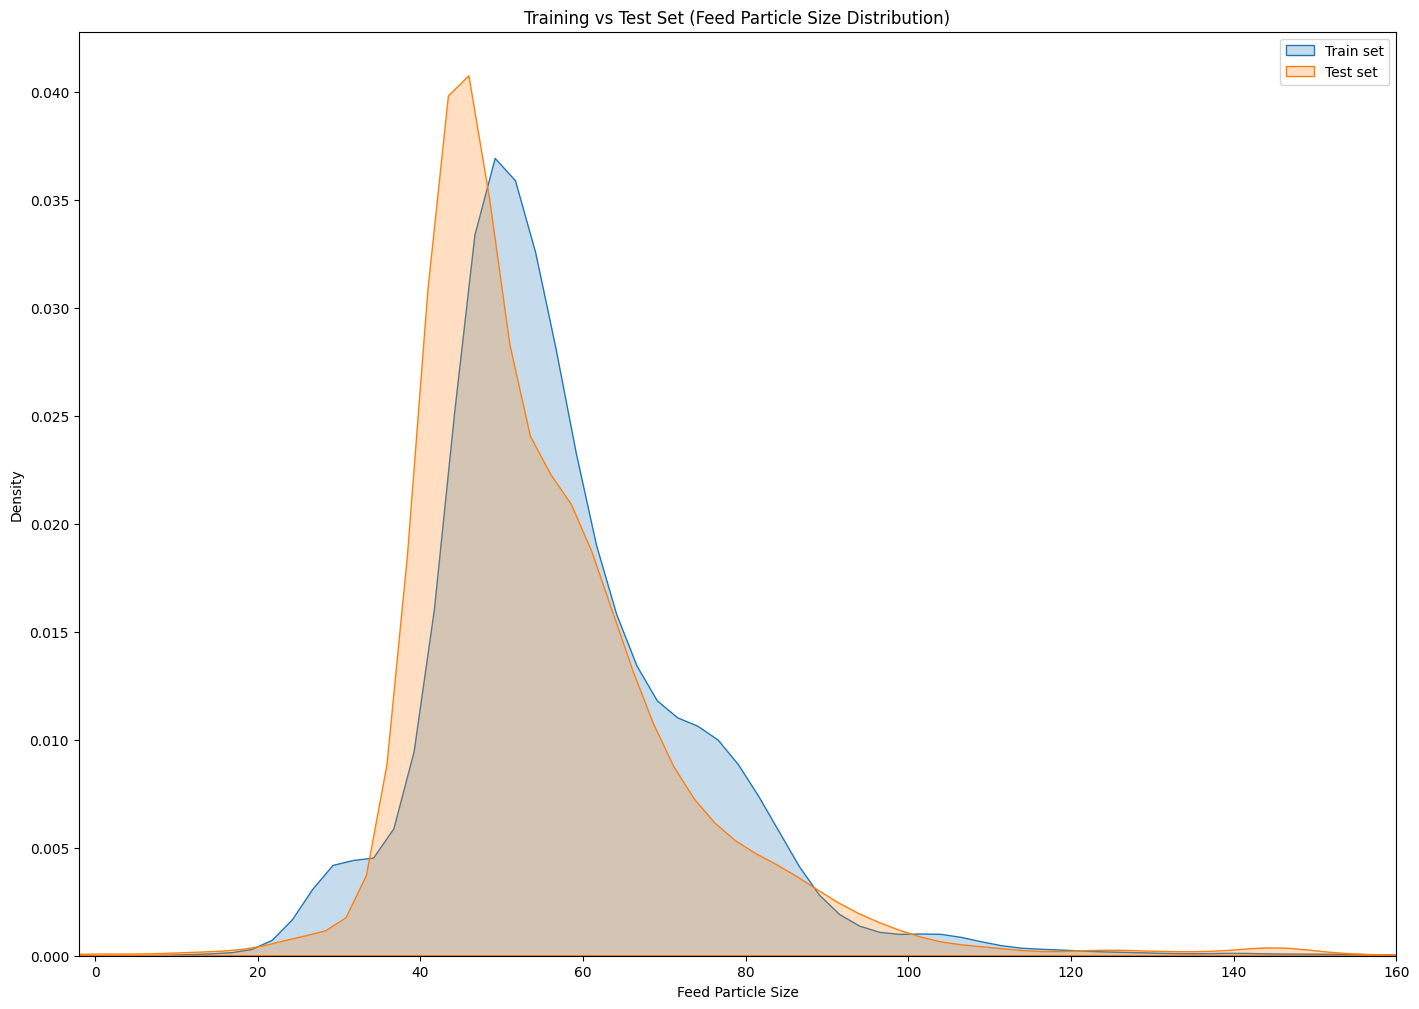

In [44]:
plt.figure(figsize=[17,12])

sns.kdeplot(df_train['rougher.input.feed_size'], fill=True, label='Train set')
sns.kdeplot(df_test['rougher.input.feed_size'], fill=True, label='Test set')

plt.legend()
plt.title('Training vs Test Set (Feed Particle Size Distribution)')
plt.xlabel('Feed Particle Size')
plt.xlim(-2,160)

plt.show()

Description: The distributions of feed particle size in both the training and test sets are very similar. The distributions are normal with a slight right skewing. 

# #Total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate

Description: An analysis of the training set data will be done to examine the total concentration of concentrate at various stages of the extraction process (raw feed, rougher concentrate, and final concentrate). This will support in determining if any abnormal values exist and if those need to be removed. The aim will be to sum the concentrations at each stage and devise a visualize of the distribution for each stage. 

In [45]:
#Raw feed 
df_train['rougher.input.total']= df_train['rougher.input.feed_ag']+df_train['rougher.input.feed_au']+df_train['rougher.input.feed_pb']

#Rougher Concentrate 
df_train['rougher.output.total']= df_train['rougher.output.concentrate_ag']+ df_train['rougher.output.concentrate_au']+ df_train['rougher.output.concentrate_pb']

#Final Concentrate 
df_train['final.output.total']= df_train['final.output.concentrate_ag']+ df_train['final.output.concentrate_au']+ df_train['final.output.concentrate_pb']



In [46]:
#show 
display(df_train['rougher.input.total'].describe())

count    16631.000000
mean        18.282239
std          7.324571
min          0.000000
25%         16.202056
50%         18.780145
75%         22.391464
max         35.071987
Name: rougher.input.total, dtype: float64

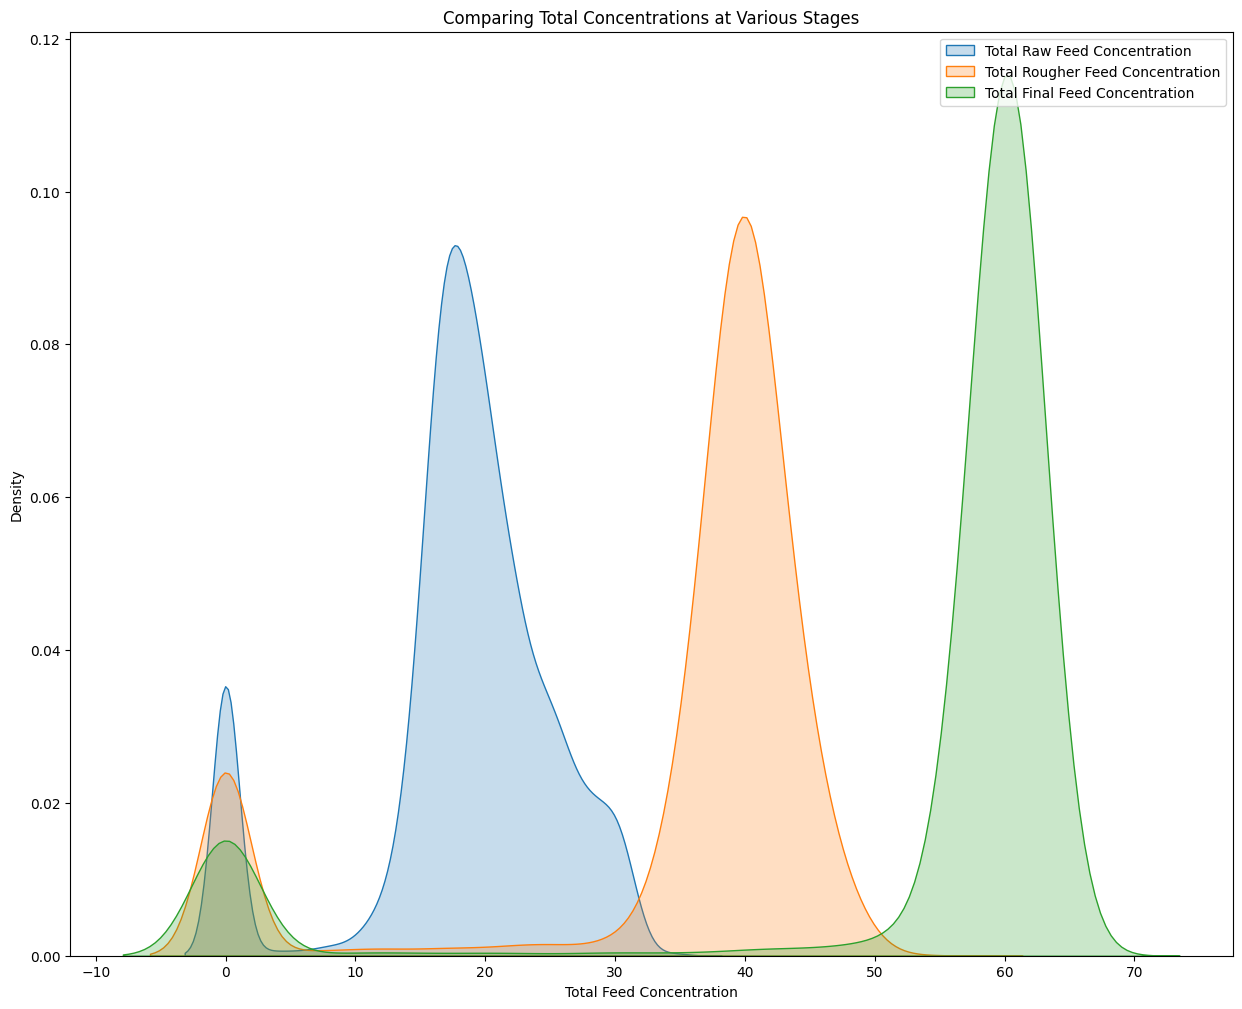

In [47]:
#plot the total raw feed 
plt.figure(figsize =[15,12])

sns.kdeplot(df_train['rougher.input.total'], fill=True, label='Total Raw Feed Concentration')
sns.kdeplot(df_train['rougher.output.total'], fill=True, label='Total Rougher Feed Concentration')
sns.kdeplot(df_train['final.output.total'], fill=True, label='Total Final Feed Concentration')

plt.legend()
plt.title ('Comparing Total Concentrations at Various Stages')
plt.xlabel('Total Feed Concentration')

plt.show()

Description: The distribution of the total concentrations look normal other than some 0s as outliers. The 0's can be removed to help normalize the dataset. 

In [48]:
#remove total concentration rows of 0 
df_train = df_train[(df_train[['rougher.input.total','rougher.output.total', 'final.output.total']] !=0).all(axis=1)]

In [49]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15178 entries, 0 to 16859
Data columns (total 90 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                15178 non-null  object 
 1   final.output.concentrate_ag                         15113 non-null  float64
 2   final.output.concentrate_pb                         15113 non-null  float64
 3   final.output.concentrate_sol                        14820 non-null  float64
 4   final.output.concentrate_au                         15114 non-null  float64
 5   final.output.recovery                               14936 non-null  float64
 6   final.output.tail_ag                                15119 non-null  float64
 7   final.output.tail_pb                                15002 non-null  float64
 8   final.output.tail_sol                               15063 non-null  float64


In [50]:
#Check missing columns in each set 
not_in_test = [x for x in df_full.columns if x not in df_test.columns]

In [51]:
not_in_test 

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Description:The list of features in the training set need to be aligned wiht the test set. Therefore we will match those up and add the two to recovery. 

In [52]:
#merge target values from full dataset to test 
df_test = pd.merge(df_test, df_full[['date','final.output.recovery', 'rougher.output.recovery']], on = 'date',how='left')


In [53]:
#drop features not in df_test from df_train 
df_train = df_train.drop([x for x in df_train if x not in df_test],axis=1)

#drop features not in df_train from df_test 
df_test = df_test.drop([x for x in df_test if x not in df_test],axis=1)

#drop date from both dataframes 
df_train = df_train.drop(['date'],axis=1)
df_test= df_test.drop(['date'],axis=1)

In [54]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15178 entries, 0 to 16859
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   final.output.recovery                       14936 non-null  float64
 1   primary_cleaner.input.sulfate               14721 non-null  float64
 2   primary_cleaner.input.depressant            14857 non-null  float64
 3   primary_cleaner.input.feed_size             15178 non-null  float64
 4   primary_cleaner.input.xanthate              14850 non-null  float64
 5   primary_cleaner.state.floatbank8_a_air      15149 non-null  float64
 6   primary_cleaner.state.floatbank8_a_level    15156 non-null  float64
 7   primary_cleaner.state.floatbank8_b_air      15149 non-null  float64
 8   primary_cleaner.state.floatbank8_b_level    15156 non-null  float64
 9   primary_cleaner.state.floatbank8_c_air      15151 non-null  float64
 10  primary_cl

In [55]:
df_test = df_test.dropna()

In [56]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15178 entries, 0 to 16859
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   final.output.recovery                       14936 non-null  float64
 1   primary_cleaner.input.sulfate               14721 non-null  float64
 2   primary_cleaner.input.depressant            14857 non-null  float64
 3   primary_cleaner.input.feed_size             15178 non-null  float64
 4   primary_cleaner.input.xanthate              14850 non-null  float64
 5   primary_cleaner.state.floatbank8_a_air      15149 non-null  float64
 6   primary_cleaner.state.floatbank8_a_level    15156 non-null  float64
 7   primary_cleaner.state.floatbank8_b_air      15149 non-null  float64
 8   primary_cleaner.state.floatbank8_b_level    15156 non-null  float64
 9   primary_cleaner.state.floatbank8_c_air      15151 non-null  float64
 10  primary_cl

Description: The missing values for the recovery features that appear in test set. Median or mean would not be an appropriate way to fill these due to the calculations made for the recovery. The simpliest solution after much trial and error is to drop the missing values from the test data. 

# Model Building 

Description: All preprocessing steps have been finsihed. It is time to reset the indexes and devise regression models. The linear regression model and the random forest regressor model will be used. The performances will be examined using cross-validation. Evaluation will be done using a symmetric mean absolute percent error (aka sMAPE). The model with the highest sMAPE will be selected and it's performance will be examined using the test set to determine a final sMAPE score. 

In [57]:
# Finalizing Preprocessing 
features_train = features_train.reset_index(drop=True)
target_train = target_train.reset_index(drop=True)

features_test = features_test.reset_index(drop=True)
target_test = target_test.reset_index(drop=True)

In [58]:
#sMAPE Calculation 
def calc_smape (actual,pred):
    N=len(actual)
    sum=0
    for i in range(N):
        numerator = abs(actual[i]-pred[i])*100 
        denominator = (abs(actual[i])+abs(pred[i])) / 2
        sum += (numerator/denominator)
    smape = sum / N 
    
    return smape 
    

In [59]:
#Final sMAPE Calculation
def combine_smapes(rougher, final):
    
    return(0.25 * rougher) + (0.75 * final)

In [60]:
#training and evaluating models 
def cross_val(features, targets, model_type, sets=5, n_estimators=10, max_depth=5):
    
    scores = []
    sample_size = int(len(features)/sets)
    
    k=0
    
    for i in range(0, len(features), sample_size):
        valid_indexes=list(range(i, i + sample_size))
        train_indexes=list(range(0, i)) + list(range(i + sample_size, len(features)))
        
        features_train = features.iloc[train_indexes].reset_index(drop=True)
        features_valid = features.iloc[valid_indexes].reset_index(drop=True)
        
        target_train = targets.iloc[train_indexes].reset_index(drop=True)
        target_valid = targets.iloc[valid_indexes].reset_index(drop=True)
        
        if model_type == 'LR':
            model = LinearRegression()
            model.fit(features_train, target_train)
            pred = pd.DataFrame(model.predict(features_valid))
        if model_type == 'RF':
            model = RandomForestRegressor(max_features=1.0, n_estimators=n_estimators, max_depth=max_depth, random_state=0)
            model.fit(features_train, target_train)
            pred = pd.DataFrame(model.predict(features_valid))
            
        rougher_recov_actual = target_valid['rougher.output.recovery']
        final_recov_actual = target_valid['final.output.recovery']
        rougher_recov_pred = pred.iloc[:,0]
        final_recov_pred = pred.iloc[:,1]
        
        rougher_smape = calc_smape(rougher_recov_actual, rougher_recov_pred)
        final_smape = calc_smape(final_recov_actual, final_recov_pred)
        combined_smape = combine_smapes(rougher_smape, final_smape)
        
        scores.append(combined_smape)
        
        k +=1
        if k == sets:
            break
            
        final_score = round(pd.Series(scores).mean(), 2)
        print(f'Ave model symmetric mean percent error:{final_score}%')
        
        

In [61]:
#sMAPE for Linear Regression 

cross_val(features_train, target_train, 'LR')

Ave model symmetric mean percent error:7.73%
Ave model symmetric mean percent error:7.79%
Ave model symmetric mean percent error:7.91%
Ave model symmetric mean percent error:7.92%


In [ ]:
#sMAPE Random Forest Regression Model 
for depth in range(15,21,1):
    print(f'max_depth:{depth}')
    cross_val(features_train, target_train, 'RF', n_estimators=20, max_depth=depth, sets=4)

max_depth:15
Ave model symmetric mean percent error:5.67%
Ave model symmetric mean percent error:5.73%
Ave model symmetric mean percent error:5.72%
max_depth:16
Ave model symmetric mean percent error:5.63%
Ave model symmetric mean percent error:5.69%
Ave model symmetric mean percent error:5.68%
max_depth:17
Ave model symmetric mean percent error:5.62%
Ave model symmetric mean percent error:5.67%
Ave model symmetric mean percent error:5.66%


Description: It will be critical to avoid overfitting the model, therefore the max_depth values will be limmitd to a maximum of 20. After 20 the gains in performance are nonexistant. This would suggest a risk of overfitting. 

In [ ]:
# Maximum depth selection 
for n_est in range(40,81,10):
    print(f'n_estimators:{n_est}')
    cross_val(features_train, target_train, 'RF', n_estimators=n_est, max_depth=20, sets=4)

Description: The improvements made based on the number of trees appears to diminish around 80 trees. Therefore, the n_estimator will be limisted to about 80 and max_depth will be 20. The random forest regression model shows a signficantly lower sMAPE as opposed to linear regression. Therefore, the random forest regression model is the better choice. This model will be trained and evalluated on its performance using the test set. 

In [ ]:
# Model Selection & training 
model_forest = RandomForestRegressor(max_features=1.0, n_estimators=80, max_depth=20, random_state=0)
model_forest.fit(features_train,target_train)
pred = pd.DataFrame(model_forest.predict(features_test))

rougher_recov_actual = target_test['rougher.output.recovery']
final_recov_actual = target_test['final.output.recovery']
rougher_recov_pred = pred.iloc[:,0]
final_recov_pred = pred.iloc[:,1]

rougher_smape = calc_smape(rougher_recov_actual, rougher_recov_pred)
final_smape = calc_smape(final_recov_actual, final_recov_pred)
combined_smape = combine_smapes(rougher_smape, final_smape)

print(f'Combined sMAPE: {round(combined_smape, 2)}%')

Description: In evaluating the model the tested combined sMAPE is slightly higher than it was during cross validation. However, it remains well below 10% which should be acceptable as Zyfra did not have a specific maximum allowable sMAPE for a model. Random Forest does require a longer processing time than, linear regression. This is acceptable as it performs better than linear regression. 

It will be critical to calculate the sMAPE for a dummy model and use it to compare it's error with the tested error and cross validated error. 

In [ ]:
# Model Evaluation 

for strategy in ['mean', 'median']:
    dummy_regr = DummyRegressor(strategy=strategy)
    dummy_regr.fit(features_train, target_train)
    pred = pd.DataFrame(dummy_regr.predict(features_test))
    
    rougher_recov_actual = target_test['rougher.output.recovery']
    final_recov_actual = target_test['final.output.recovery']
    rougher_recov_pred = pred.iloc[:,0]
    final_recov_pred = pred.iloc[:,1]
    
    rougher_smape = calc_smape(rougher_recov_actual, rougher_recov_pred)
    final_smape = calc_smape(final_recov_actual, final_recov_pred)
    combined_smape = combine_smapes(rougher_smape, final_smape)
    
    print(f'Combined sMAPE with {strategy}:{round(combined_smape,2)}%')
    

Description: The tested sMAPE is slighly less than the dummy sMAPE when evaluating using the mean. However, it is slightly more than when evaluating using the dummy median sMAPE. The cross-validated sMAPE is notably lower than either dummy error mean or median. This would suggest the model appears to perform successfully than the simple prediction provided by using the mean or median. 

# Conclusion

The objective of the model was to construct a model predicting gold concentrate recovery for both the rougher and final stages of extraction. The data provided by Zyfra consisted of three datasets. A full dataset, a training and a test set. The test set contained only features present at the start of the extraction process. The performance of the model was evaluated using sMAPE and arrived at based on weighted average of the two recoveries. It was critical to examine the provided recovery data, therefore it was verfied that the calculated recovery was correct. In addition metal concentration was analyzed at each stage of extraction and filtered based on the observations. Feed size distribution was examined for both the training and test sets to ensure that the data was similar. During the preprocessing of the data missing values were taken care of and datasets were trimmed to ensure the validity of the dataset. 

Cross validation was used for linear regression and random forest regression models. Based on the results it was concluded that random forest due to its sMAPE score outperformed the linear regression model. The model was subsequently trained using specific hyperparameters based on the complete training set and yieled an acceptable result when compared against a dummy model. This suggest it the model is capable of providing valuable insights for future use. 
